In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

In [54]:
df = pd.read_csv("fetal_health.csv")
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().astype(int)


In [55]:
print("Original Class Distribution:", Counter(y))


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


y_resampled = y_resampled.astype(int)


print("After SMOTE Class Distribution:", Counter(y_resampled))


Original Class Distribution: Counter({1: 1655, 2: 295, 3: 176})
After SMOTE Class Distribution: Counter({2: 1655, 1: 1655, 3: 1655})


In [56]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [57]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [58]:
class ManualKNN:
    def __init__(self, k=25):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_neighbors = np.argsort(distances)[:self.k]
            labels = [self.y_train[i] for i in k_neighbors]
            predictions.append(Counter(labels).most_common(1)[0][0])
        return np.array(predictions)

    def predict_proba(self, X):
        proba = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_neighbors = np.argsort(distances)[:self.k]
            labels = [self.y_train[i] for i in k_neighbors]

            # Compute inverse distance weights
            weights = 1 / (distances[k_neighbors] + 1e-5)  # Adding small value to avoid division by zero
            label_counts = Counter()
            for i, label in enumerate(labels):
                label_counts[label] += weights[i]  # Assigning weights

            total = sum(label_counts.values())

            # Normalize counts to get probabilities
            probs = {key: value / total for key, value in label_counts.items()}
            proba.append([probs.get(cls, 0) for cls in np.unique(self.y_train)])

        return np.array(proba)


In [59]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class ManualDecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        if depth >= self.max_depth or len(unique_classes) == 1 or num_samples < self.min_samples_split:
            return Node(value=Counter(y).most_common(1)[0][0])

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return Node(value=Counter(y).most_common(1)[0][0])

        left_idx = X[:, best_feature] <= best_threshold
        right_idx = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = X[:, feature] > threshold
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gain = self._information_gain(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _entropy(self, y):
        values, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))

    def _information_gain(self, y, y_left, y_right):
        return self._entropy(y) - (len(y_left) / len(y) * self._entropy(y_left) + len(y_right) / len(y) * self._entropy(y_right))

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _predict(self, x, node):
        if node.value is not None:
            return node.value
        return self._predict(x, node.left if x[node.feature] <= node.threshold else node.right)


In [60]:
class ManualRandomForest:
    def __init__(self, n_trees=100, max_depth=7, min_samples_split=5):
        self.n_trees = n_trees
        self.trees = [ManualDecisionTree(max_depth, min_samples_split) for _ in range(n_trees)]

    def fit(self, X, y):
        for tree in self.trees:
            idxs = np.random.choice(len(X), len(X), replace=True)
            tree.fit(X[idxs], y[idxs])

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

    def predict_proba(self, X):
        """Compute class probabilities by averaging tree predictions."""
        predictions = np.array([tree.predict(X) for tree in self.trees])
        n_samples = X.shape[0]
        unique_classes = np.unique(predictions)  # Get the unique class labels
        class_to_index = {cls: i for i, cls in enumerate(unique_classes)}  # Map class labels to indices

        proba = np.zeros((n_samples, len(unique_classes)))  # Adjust probability array size

        for i in range(n_samples):
            class_counts = Counter(predictions[:, i])  # Count votes per class
            total_votes = sum(class_counts.values())
            for cls, count in class_counts.items():
                proba[i, class_to_index[cls]] = count / total_votes  # Map to correct index

        return proba



In [61]:
class ManualGradientBoosting:
    def __init__(self, n_estimators=200, learning_rate=0.01):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X, y):
        """Fit the gradient boosting model using decision trees."""
        self.classes_ = np.unique(y)
        y_encoded = np.array([np.where(self.classes_ == label)[0][0] for label in y])
        residuals = np.zeros((y.shape[0], len(self.classes_)))

        for i, class_label in enumerate(self.classes_):
            binary_y = (y_encoded == i).astype(float)
            tree = ManualDecisionTree(max_depth=15, min_samples_split=2)  # Regularization applied
            tree.fit(X, binary_y)
            self.models.append(tree)

            residuals[:, i] = binary_y - tree.predict(X)  # Compute residuals

            # Apply learning rate scaling
            residuals[:, i] *= self.learning_rate

    def predict(self, X):
        """Predict the class labels."""
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    def predict_proba(self, X):
        raw_preds = np.zeros((X.shape[0], len(self.classes_)))
        for i, tree in enumerate(self.models):
            raw_preds[:, i] = tree.predict(X)

        exp_preds = np.exp(raw_preds - np.max(raw_preds, axis=1, keepdims=True))
        return np.clip(exp_preds / np.sum(exp_preds, axis=1, keepdims=True), 1e-7, 1-1e-7)  # Prevent log(0) errors



In [62]:
models = {

    "KNN": ManualKNN(k=25) ,
    "Random Forest": ManualRandomForest(),
    "Gradient Boosting": ManualGradientBoosting()

}


KNN
Train Accuracy: 91.94%
Validation Accuracy: 90.34%
Test Accuracy: 88.46%
Train Loss: 0.0004
Validation Loss: 0.1682
Test Loss: 0.3032
              precision    recall  f1-score   support

           1       0.99      0.77      0.87       245
           2       0.81      0.93      0.87       277
           3       0.89      0.95      0.92       223

    accuracy                           0.88       745
   macro avg       0.90      0.88      0.89       745
weighted avg       0.90      0.88      0.88       745



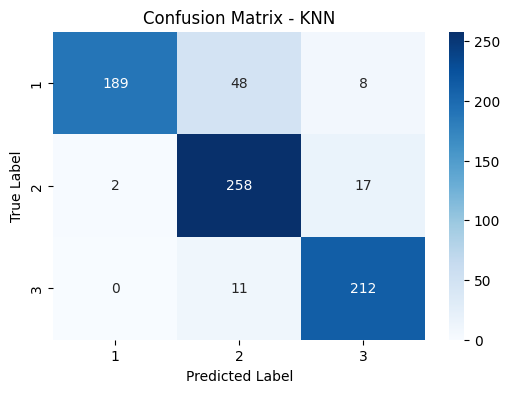


Random Forest
Train Accuracy: 96.78%
Validation Accuracy: 96.38%
Test Accuracy: 93.69%
Train Loss: 0.1235
Validation Loss: 0.1908
Test Loss: 0.2632
              precision    recall  f1-score   support

           1       0.94      0.89      0.91       245
           2       0.90      0.96      0.93       277
           3       0.99      0.96      0.97       223

    accuracy                           0.94       745
   macro avg       0.94      0.94      0.94       745
weighted avg       0.94      0.94      0.94       745



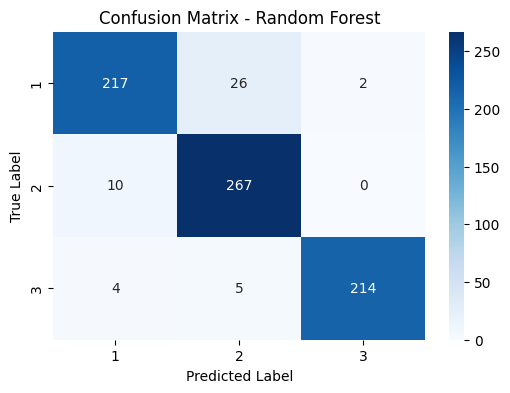


Gradient Boosting
Train Accuracy: 99.86%
Validation Accuracy: 96.11%
Test Accuracy: 95.30%
Train Loss: 0.5522
Validation Loss: 0.5852
Test Loss: 0.5925
              precision    recall  f1-score   support

           1       0.92      0.97      0.94       245
           2       0.96      0.94      0.95       277
           3       1.00      0.95      0.97       223

    accuracy                           0.95       745
   macro avg       0.96      0.95      0.95       745
weighted avg       0.95      0.95      0.95       745



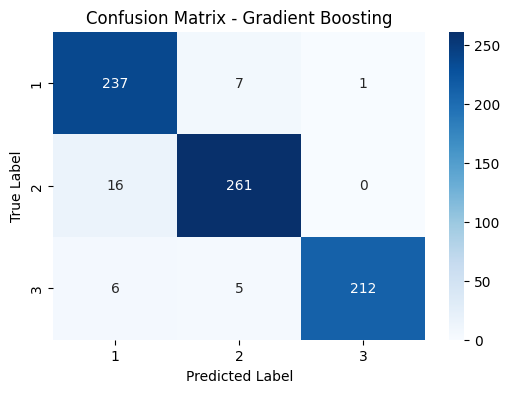

In [63]:
# One-hot encoding for true labels
encoder = OneHotEncoder(sparse_output=False)  # Corrected to avoid deprecated "sparse=False"
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.transform(y_val.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    # Get predicted classes
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Get predicted probabilities (FIXED)
    y_train_pred_proba = model.predict_proba(X_train_scaled)
    y_val_pred_proba = model.predict_proba(X_val_scaled)
    y_test_pred_proba = model.predict_proba(X_test_scaled)

    # Accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred) * 100  # Convert to percentage
    val_acc = accuracy_score(y_val, y_val_pred) * 100
    test_acc = accuracy_score(y_test, y_test_pred) * 100

    # Log loss calculation (FIXED)
    train_loss = log_loss(y_train_onehot, y_train_pred_proba)
    val_loss = log_loss(y_val_onehot, y_val_pred_proba)
    test_loss = log_loss(y_test_onehot, y_test_pred_proba)

    print(f"\n{name}")
    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    print(classification_report(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()



Voting Ensemble - Accuracy and Loss:
Train Accuracy: 97.87%
Validation Accuracy: 96.78%
Test Accuracy: 94.77%
Train Loss: 0.1759
Validation Loss: 0.2470
Test Loss: 0.2767

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.89      0.93       245
           2       0.90      0.99      0.94       277
           3       1.00      0.96      0.98       223

    accuracy                           0.95       745
   macro avg       0.95      0.95      0.95       745
weighted avg       0.95      0.95      0.95       745



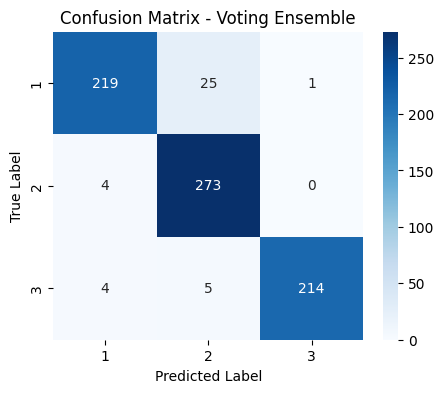

In [64]:

class VotingEnsemble:
    def __init__(self, models, known_classes):
        """
        :param models: Dictionary of trained models
        :param known_classes: List of all possible class labels
        """
        self.models = models
        self.known_classes = np.array(known_classes)  # Convert to numpy array for indexing

    def fit(self, X, y):
        """Train all models on the dataset."""
        for model in self.models.values():
            model.fit(X, y)

    def predict(self, X):
        """Predict final class labels using majority voting."""
        predictions = np.array([model.predict(X) for model in self.models.values()])
        final_predictions = np.apply_along_axis(lambda x: self.majority_vote(x), axis=0, arr=predictions)
        return final_predictions

    def predict_proba(self, X):
        """Averages predicted probabilities from all models."""
        probs_list = []

        for model in self.models.values():
            proba = model.predict_proba(X)
            if proba.shape[1] != len(self.known_classes):
                raise ValueError(f"Model output shape {proba.shape} does not match expected {len(self.known_classes)} classes")

            probs_list.append(proba)

        avg_probs = np.mean(probs_list, axis=0)  # Average probabilities across all models
        return avg_probs

    def majority_vote(self, predictions):
        """Returns the most frequent class label among model predictions."""
        counter = Counter(predictions)
        most_common_label, _ = counter.most_common(1)[0]

        # Ensure the predicted label is within known classes
        if most_common_label in self.known_classes:
            return most_common_label
        else:
            return max(self.known_classes, key=lambda c: counter[c])  # Choose the class with the highest votes among known classes


# Initialize Models
models = {
    "knn": ManualKNN(k=25),
    "random_forest": ManualRandomForest(n_trees=100, max_depth=7, min_samples_split=5),
    "gradient_boosting": ManualGradientBoosting(n_estimators=200, learning_rate=0.01)
}

# Define Known Classes
known_classes = np.unique(y_train)

# Initialize Ensemble Model
ensemble_model = VotingEnsemble(models, known_classes)

# Train the model
ensemble_model.fit(X_train_scaled, y_train)

# Predict classes
y_train_pred_ensemble = ensemble_model.predict(X_train_scaled)
y_val_pred_ensemble = ensemble_model.predict(X_val_scaled)
y_test_pred_ensemble = ensemble_model.predict(X_test_scaled)

# One-hot encode the true labels for loss calculation
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_onehot = lb.fit_transform(y_train)
y_val_onehot = lb.transform(y_val)
y_test_onehot = lb.transform(y_test)

# Predict probabilities
y_train_pred_proba_ensemble = ensemble_model.predict_proba(X_train_scaled)
y_val_pred_proba_ensemble = ensemble_model.predict_proba(X_val_scaled)
y_test_pred_proba_ensemble = ensemble_model.predict_proba(X_test_scaled)

# Compute Accuracy
train_acc = accuracy_score(y_train, y_train_pred_ensemble) * 100
val_acc = accuracy_score(y_val, y_val_pred_ensemble) * 100
test_acc = accuracy_score(y_test, y_test_pred_ensemble) * 100

# Compute Log Loss
train_loss = log_loss(y_train_onehot, y_train_pred_proba_ensemble)
val_loss = log_loss(y_val_onehot, y_val_pred_proba_ensemble)
test_loss = log_loss(y_test_onehot, y_test_pred_proba_ensemble)

# Print results
print("\nVoting Ensemble - Accuracy and Loss:")
print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification Report
print("\nClassification Report:")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_test_pred_ensemble, zero_division=1))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred_ensemble), annot=True, fmt="d", cmap="Blues", xticklabels=known_classes, yticklabels=known_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Voting Ensemble")
plt.show()
